In [1]:
import time
import scipy.io as scio
import numpy as np
from multiprocessing import Pool
import sys
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
from MDPD import utils, readers, MDPD

## Utilities

In [2]:
def show_img(arrays, figsize=None):
    "show image(s) in parallel"
    n = len(arrays)
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    for i in xrange(n):
        plt.subplot(n,1,i+1)
        plt.imshow(arrays[i].reshape((28,28)))
    plt.show()

## Read Data

In [3]:
folder = "/media/vzhao/Data/MNIST"
folder = "/Users/vincent/Documents/Research/MDPD/MNIST"
mnist = readers.MNIST_Reader(folder, binarized=True)
train, labels = mnist.train, mnist.labels
_, dim, _ = train.shape

Extracting /Users/vincent/Documents/Research/MDPD/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# data per digit
train_uni = [None] * 10
for dig in xrange(10):
    train_uni[dig] = train[labels==dig,...]
# small sample
train_small = train[:5000,...]
labels_small = labels[:5000]

### Pick a data source

In [5]:
data, labs = train_small, labels_small

## Information residue as in raw data

MDPD/utils.py:204: RuntimeWarning: divide by zero encountered in log
  pmi = second * (np.log(second) - log_first)
MDPD/utils.py:204: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (np.log(second) - log_first)


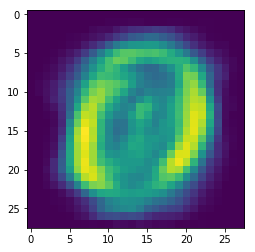

Information residue in raw data
0.00263756810177
CPU times: user 1.84 s, sys: 216 ms, total: 2.06 s
Wall time: 1.22 s


In [6]:
%%time
score_origin = utils.Feature_Selection.MI_score(data, rm_diag=True)
sigma_origin = score_origin.sum(axis=1)
show_img([sigma_origin])
print 'Information residue in raw data'
print sigma_origin.mean() / (dim - 1)

#### Reference G score

In [7]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * data.shape[0]) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.0011344866730144372, 0.0007814727903251177, 0.00062513886311703229, 0.00041083449356323163, 0.00023659738843753378]


### Mutual Information Residue if ues the labels as the posterior distribution

In [8]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(labs,labs.max()+1)
utils.log_replace_neginf(log_post)

/Users/vincent/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [9]:
%%time
score, weighted = MDPD.utils.Feature_Selection.MI_score_conditional(data, log_post, rm_diag=True)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(sigma_condition * weighted[np.newaxis, :]) / (dim * (dim - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.00308653525805
CPU times: user 32.6 s, sys: 3.98 s, total: 36.5 s
Wall time: 22.9 s


#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

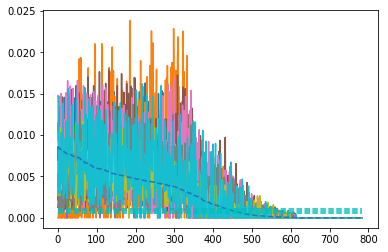

In [10]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(10):
    plt.plot(sigma_condition[idx,k]/(dim-1))
plt.plot(sigma_origin[idx] / (dim-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

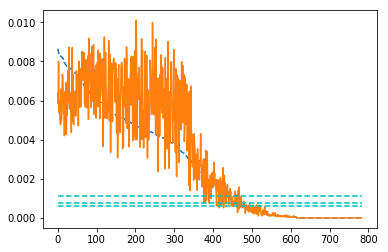

In [11]:
plt.figure()
plt.plot(sigma_origin[idx] / (dim-1), '--')
plt.plot(np.sum(sigma_condition[idx, ...] * weighted[np.newaxis, :], axis=1) / (dim-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

#### [Plot] Mutual information residue conditional on a digit vs Raw MIS

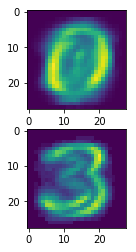

In [22]:
show_img([sigma_origin, sigma_condition[:,3]])

#### Conditional MIS vs Raw MIS

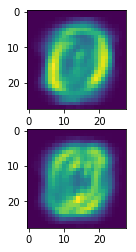

In [13]:
show_img([sigma_origin, np.sum(sigma_condition * weighted[np.newaxis, :], axis=1)])

#### Conclusion

A naive mixture model is not a good generative model of MNIST data set.

## Train a MDPD with the selected features

In [14]:
%%time
features, _ = utils.Feature_Selection.MI_feature_ranking(data)

CPU times: user 1.58 s, sys: 185 ms, total: 1.77 s
Wall time: 1 s


#### Top Ntop features

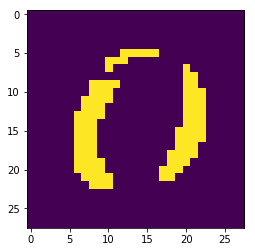

In [15]:
Ntop = 100
img = np.zeros(dim)
img[features[:Ntop]] = 1
show_img([img])

In [16]:
%%time
model1 = MDPD.MDPD()
model1.fit(data, ncomp=10, init='random', verbose=True, features=features[:Ntop], epoch=50)

2018-04-04 01:00:18,338 : INFO : Training an MDPD with dimension 784, 100 features, sample size 5000, vocab size 2 and the target number of components 10
2018-04-04 01:00:23,488 : INFO : iteration 0; log-likelihood (feature selection) -43.476854; log_likelihood -183.931975
2018-04-04 01:00:28,805 : INFO : iteration 1; log-likelihood (feature selection) -39.710432; log_likelihood -175.084165
2018-04-04 01:00:35,010 : INFO : iteration 2; log-likelihood (feature selection) -38.878033; log_likelihood -172.980791
2018-04-04 01:00:40,792 : INFO : iteration 3; log-likelihood (feature selection) -38.463318; log_likelihood -172.054744
2018-04-04 01:00:45,659 : INFO : iteration 4; log-likelihood (feature selection) -38.250139; log_likelihood -171.620523
2018-04-04 01:00:50,462 : INFO : iteration 5; log-likelihood (feature selection) -38.122242; log_likelihood -171.367696
2018-04-04 01:00:55,218 : INFO : iteration 6; log-likelihood (feature selection) -38.042231; log_likelihood -171.219559
2018-0

CPU times: user 2min 41s, sys: 1min 20s, total: 4min 2s
Wall time: 4min 19s


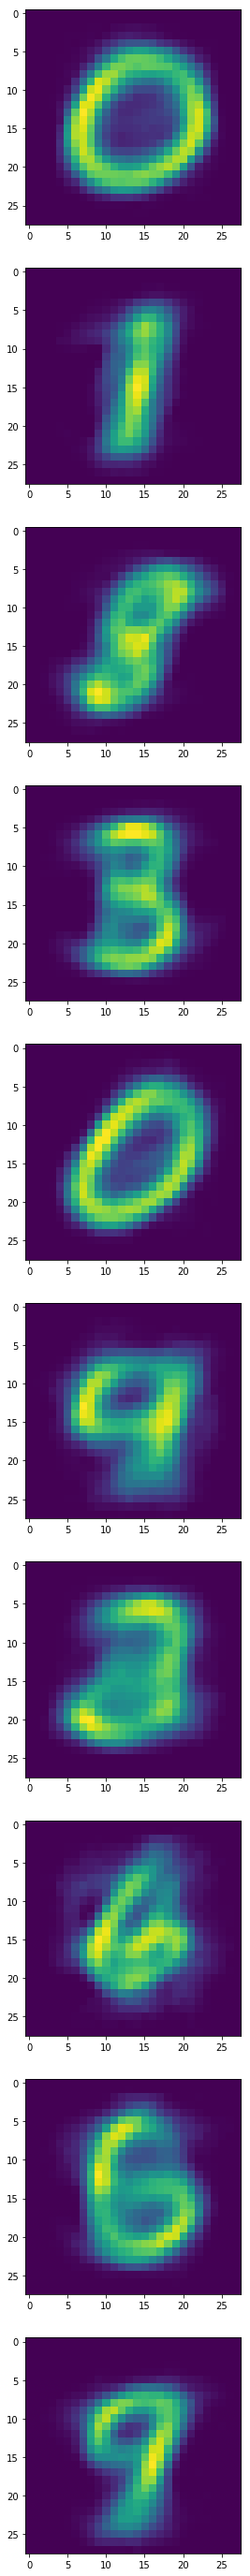

In [18]:
show_img(np.exp([model1.logC[:,0,i] for i in xrange(10)]), figsize=(50,50))

In [ ]:
model1.logC.shape

In [ ]:
img = np.zeros(dim)
img[features[:Ntop]] = np.exp(model1.logC[:,0,1])
plt.imshow(img.reshape((28,28)))

In [ ]:
foo.shape